In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import seaborn as sns
from scipy.special import rel_entr

In [2]:
# List of available dataset
df18 = pd.read_csv("../exp1-inf/predictions_res18.csv")
df50 = pd.read_csv("../exp1-inf/predictions_res50.csv")
df101 = pd.read_csv("../exp1-inf/predictions_res101.csv")
label = pd.read_csv("../exp1-inf/labels.csv")
prediction = pd.DataFrame({
    "pred18": df18.idxmax(axis=1),
    "pred50": df50.idxmax(axis=1),
    "pred101": df101.idxmax(axis=1),
    "target": label['target']
})
prediction["pred18"] = prediction["pred18"].str.extract('(\d+)').astype(int)
prediction["pred50"] = prediction["pred50"].str.extract('(\d+)').astype(int)
prediction["pred101"] = prediction["pred101"].str.extract('(\d+)').astype(int)

In [3]:
prediction.head()

,pred18,pred50,pred101,target
0,12,68,76,49
1,33,16,33,33
2,30,55,72,72
3,51,51,51,51
4,71,71,71,71


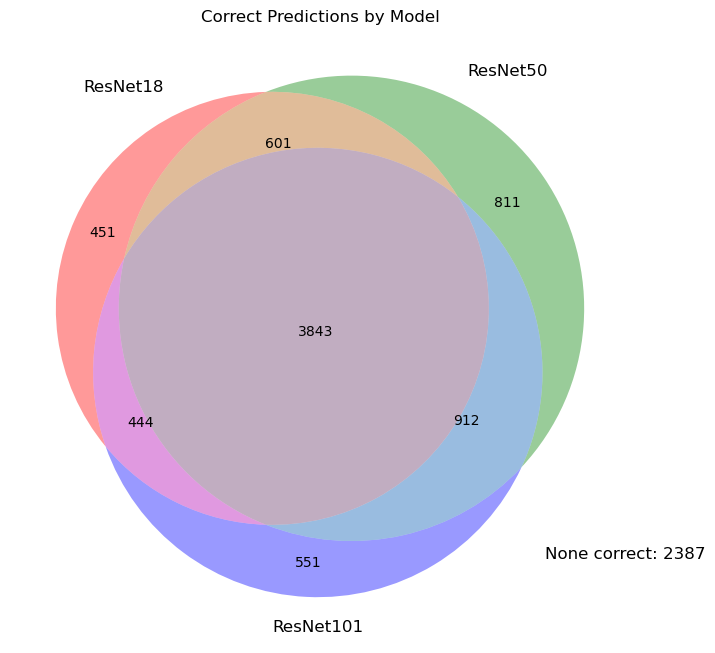

In [4]:
# Accuracy Venn Diagram:
df = prediction
correct_18 = set(df[df['pred18'] == df['target']].index)
correct_50 = set(df[df['pred50'] == df['target']].index)
correct_101 = set(df[df['pred101'] == df['target']].index)
total_indices = set(df.index)
incorrect_all = total_indices - (correct_18 | correct_50 | correct_101)
plt.figure(figsize=(8, 8))
venn_diagram = venn3([correct_18, correct_50, correct_101], ('ResNet18', 'ResNet50', 'ResNet101'))
plt.title('Correct Predictions by Model')
plt.text(0.5, -0.5, f'None correct: {len(incorrect_all)}', fontsize=12)
plt.show()

ou_res18=0.36751593504088775 | ou_res50=0.2588155342712535 | ou_res101=0.28971527020996146


Text(0, 0.5, 'Density')

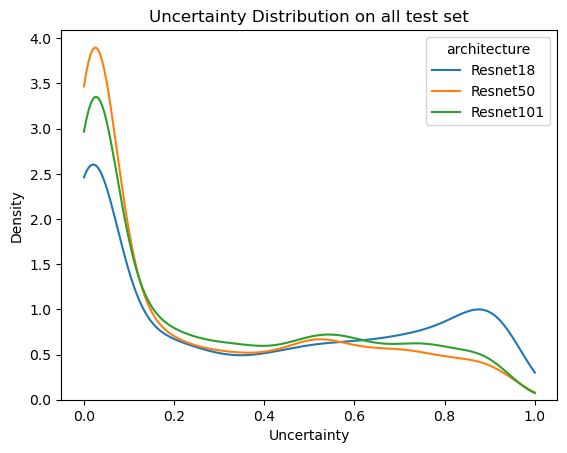

In [5]:
# Uncertainty Visualization
df18["uncertainty"]=1-df18.pow(2).sum(axis=1) # Brier Score
df50["uncertainty"]=1-df50.pow(2).sum(axis=1)
df101["uncertainty"]=1-df101.pow(2).sum(axis=1)
ou_res18 = df18["uncertainty"].mean()
ou_res50 = df50["uncertainty"].mean()
ou_res101 = df101["uncertainty"].mean()
print(f"{ou_res18=} | {ou_res50=} | {ou_res101=}")
sns.kdeplot(df18['uncertainty'], clip=[0, 1], label='Resnet18')
sns.kdeplot(df50['uncertainty'], clip=[0, 1], label='Resnet50')
sns.kdeplot(df101['uncertainty'], clip=[0, 1], label='Resnet101')
plt.legend(title='architecture')
plt.title('Uncertainty Distribution on all test set')
plt.xlabel('Uncertainty')
plt.ylabel('Density')

oc_res18=0.8715682656677265 | oc_res50=0.8837061005793636 | oc_res101=0.8710843226908104


Text(0, 0.5, 'Density')

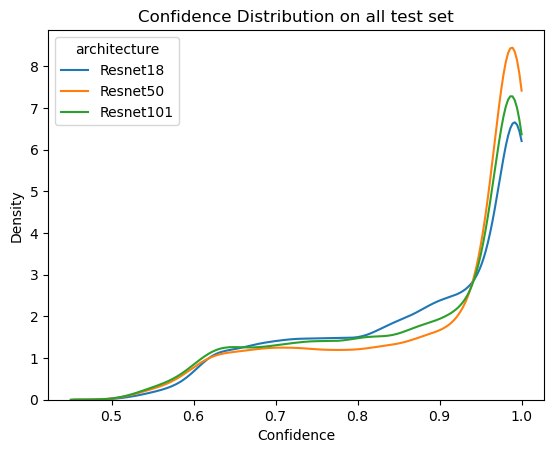

In [6]:
df18["confidence"]=df18.max(axis=1) # prediction confidence
df50["confidence"]=df50.max(axis=1)
df101["confidence"]=df101.max(axis=1)
oc_res18 = df18["confidence"].mean()
oc_res50 = df50["confidence"].mean()
oc_res101 = df101["confidence"].mean()
print(f"{oc_res18=} | {oc_res50=} | {oc_res101=}")
sns.kdeplot(df18['confidence'], clip=[0, 1], label='Resnet18')
sns.kdeplot(df50['confidence'], clip=[0, 1], label='Resnet50')
sns.kdeplot(df101['confidence'], clip=[0, 1], label='Resnet101')
plt.title('Confidence Distribution on all test set')
plt.legend(title='architecture')
plt.xlabel('Confidence')
plt.ylabel('Density')

,pred18,pred50,pred101,target,cor18,cor50,cor101,kl_18_50,kl_18_101,kl_50_18,kl_50_101,kl_101_18,kl_101_50
0,12,68,76,49,0,0,0,4.386427,2.225955,3.239526,1.160255,2.074433,2.595878
1,33,16,33,33,1,0,1,2.993234,0.459175,4.997466,3.678840,2.010365,2.688443


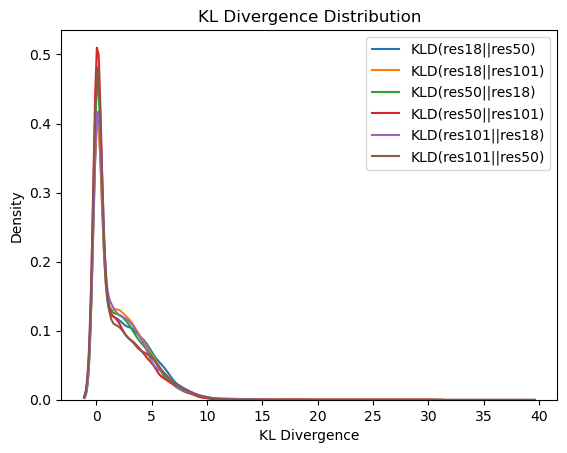

In [7]:
df["cor18"] = np.where(df["pred18"]==df["target"],1,0)
df["cor50"] = np.where(df["pred50"]==df["target"],1,0)
df["cor101"] = np.where(df["pred101"]==df["target"],1,0)
def calc_kl(Q,P,numclass):
    return rel_entr(Q.iloc[:,0:numclass],P.iloc[:,0:numclass]).sum(1)
df["kl_18_50"] = calc_kl(df18,df50,100)
df["kl_18_101"] = calc_kl(df18,df101,100)
df["kl_50_18"] = calc_kl(df50,df18,100)
df["kl_50_101"] = calc_kl(df50,df101,100)
df["kl_101_18"] = calc_kl(df101,df18,100)
df["kl_101_50"] = calc_kl(df101,df50,100)
display(df.head(2))
sns.kdeplot(df["kl_18_50"], label='KLD(res18||res50)')
sns.kdeplot(df["kl_18_101"], label='KLD(res18||res101)')
sns.kdeplot(df["kl_50_18"], label='KLD(res50||res18)')
sns.kdeplot(df["kl_50_101"], label='KLD(res50||res101)')
sns.kdeplot(df["kl_101_18"], label='KLD(res101||res18)')
sns.kdeplot(df["kl_101_50"], label='KLD(res101||res50)')
plt.title('KL Divergence Distribution')
plt.xlabel('KL Divergence')
plt.ylabel('Density')
plt.legend()

bin_kl
(-0.00988, 1.0]    4515
(1.0, 2.0]         1204
(2.0, 3.0]         1087
(3.0, 4.0]          992
(4.0, 5.0]          831
(5.0, 6.0]          575
(6.0, 7.0]          374
(7.0, 8.0]          200
(8.0, 9.0]          119
(9.0, 10.0]         103
Name: count, dtype: int64


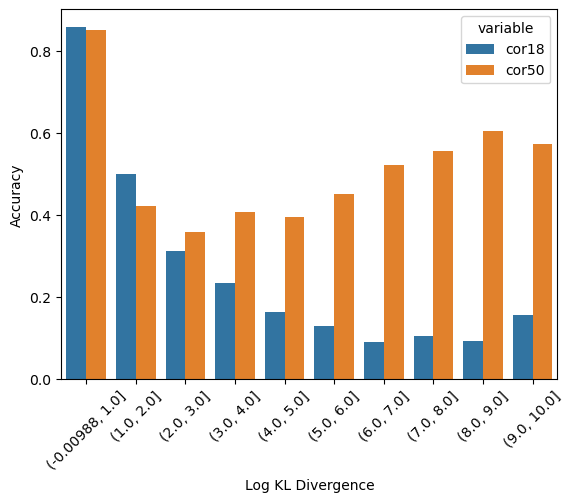

bin_kl
(-0.00989, 1.0]    4449
(1.0, 2.0]         1279
(2.0, 3.0]         1258
(3.0, 4.0]         1029
(4.0, 5.0]          786
(5.0, 6.0]          531
(6.0, 7.0]          315
(7.0, 8.0]          177
(8.0, 9.0]           94
(9.0, 10.0]          82
Name: count, dtype: int64


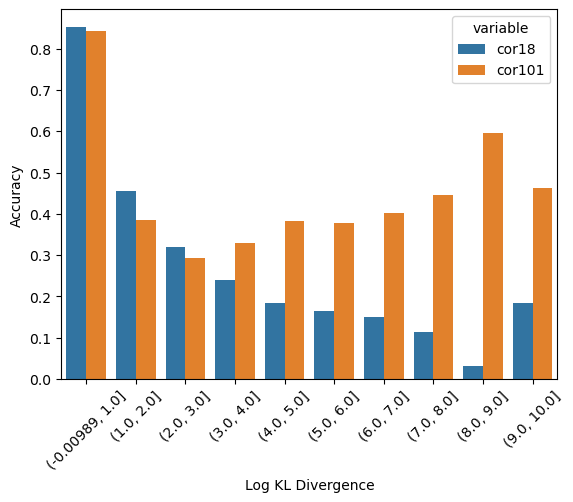

bin_kl
(-0.00992, 1.0]    4791
(1.0, 2.0]         1238
(2.0, 3.0]         1186
(3.0, 4.0]          943
(4.0, 5.0]          754
(5.0, 6.0]          501
(6.0, 7.0]          273
(7.0, 8.0]          149
(8.0, 9.0]           96
(9.0, 10.0]          69
Name: count, dtype: int64


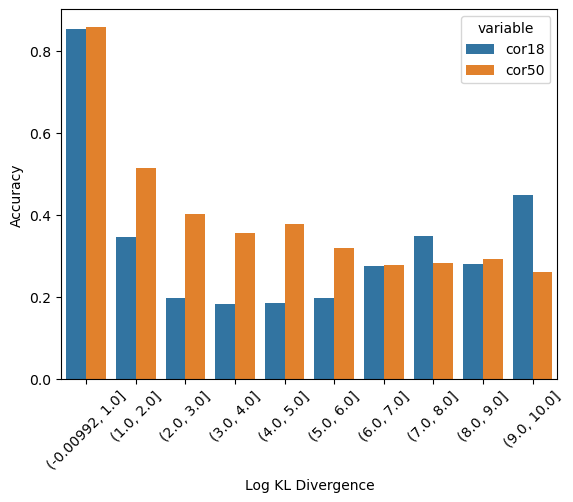

bin_kl
(-0.00966, 1.0]    5405
(1.0, 2.0]         1199
(2.0, 3.0]          959
(3.0, 4.0]          814
(4.0, 5.0]          616
(5.0, 6.0]          413
(6.0, 7.0]          271
(7.0, 8.0]          166
(8.0, 9.0]           88
(9.0, 10.0]          69
Name: count, dtype: int64


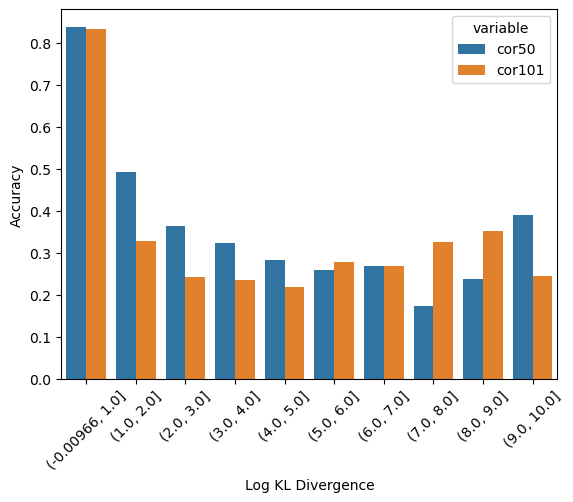

bin_kl
(-0.00972, 1.0]    4568
(1.0, 2.0]         1348
(2.0, 3.0]         1184
(3.0, 4.0]         1016
(4.0, 5.0]          741
(5.0, 6.0]          444
(6.0, 7.0]          314
(7.0, 8.0]          167
(8.0, 9.0]           98
(9.0, 10.0]         120
Name: count, dtype: int64


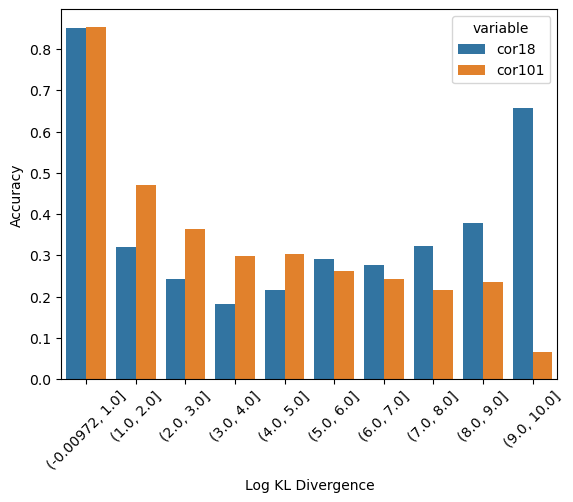

bin_kl
(-0.00973, 1.0]    5260
(1.0, 2.0]         1098
(2.0, 3.0]          966
(3.0, 4.0]          777
(4.0, 5.0]          669
(5.0, 6.0]          522
(6.0, 7.0]          311
(7.0, 8.0]          186
(8.0, 9.0]          113
(9.0, 10.0]          98
Name: count, dtype: int64


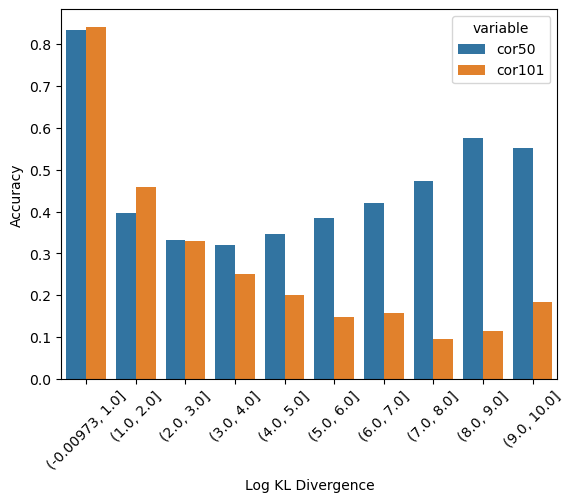

In [15]:
binnum=10
def bin_kl_vis(df_in, binnum,kl_name,acc_col1,acc_col2):
    df=df_in
    tempcol = "bin_kl"
    df[tempcol] = pd.cut(df[kl_name].clip(-20,10), bins=binnum)
    print(df[tempcol].value_counts().sort_index())
    grouped = df.groupby(tempcol)[[acc_col1,acc_col2]].mean().reset_index()
    melted_grouped = grouped.melt(id_vars=tempcol, var_name='variable', value_name='value')
    sns.barplot(x=tempcol, y='value', hue='variable', data=melted_grouped)
    plt.xticks(rotation=45)
    plt.xlabel("Log KL Divergence")
    plt.ylabel("Accuracy")
    plt.show()
bin_kl_vis(df, binnum, "kl_18_50", "cor18", "cor50")
bin_kl_vis(df, binnum, "kl_18_101", "cor18", "cor101")
bin_kl_vis(df, binnum, "kl_50_18", "cor18", "cor50")
bin_kl_vis(df, binnum, "kl_50_101", "cor50", "cor101")
bin_kl_vis(df, binnum, "kl_101_18", "cor18", "cor101")
bin_kl_vis(df, binnum, "kl_101_50", "cor50", "cor101")